# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). 


In [91]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import add_months, avg, count, countDistinct, col, datediff,\
desc, expr, from_unixtime, floor, isnan, lag, lit, month, months_between,\
min, max, split, sum, udf, unix_timestamp, when, year
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from datetime import datetime

In [92]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [93]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [94]:
df = spark.read.json("mini_sparkify_event_data.json")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [95]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [96]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

### Investigate timestamps

In [97]:
df.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810483...|
| stddev|1.5075439608226302E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [98]:
ts = int(1538352117000)
ts /= 1000
print("Start Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

ts = int(1543799476000)
ts /= 1000
print("End Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

Start Time: 2018-10-01 00:01:57
End Time: 2018-12-03 01:11:16


### Investigate pages

In [99]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



### Investigate timestamps

In [108]:
# check NaN values per column
# taken from: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [109]:
# check null values per column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [110]:
df.filter(col("firstName").isNull()).show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [111]:
df.filter((col("firstName").isNull()) & (col("gender").isNotNull())).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [112]:
df.filter((col("firstName").isNull()) & (col("lastName").isNotNull())).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



Entries with missing firstName are also missing gender, lastName, location, registration, userAgent

In [113]:
df.filter(col("firstName").isNull()).select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [114]:
# entries with missing firstname but with paid level are logging out
df.filter((col("firstName").isNull()) & (col("level")=="paid")).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|           49|    null|  null| paid|    null|   GET| Home|        null|      141|null|   200|1538381499000|     null|      |
|  null|Logged Out|     null|  null|           50|    null|  null| paid|    null|   PUT|Login|        null|      141|null|   307|1538381500000|     null|      |
|  null|Logged Out|     null|  null|           57|    null|  null| paid|    null|   GET| Home|        null|      141|null|   200|1538382349000|     null|      |
|  null|Logged Out|     null|  nul

We can just discard the data with missing firstName, lastName.

### Data preprocessing

In [115]:
# filter out all entries with missing names.
# they are not recording information that we will need for the model
df = df.filter(df.firstName.isNotNull())

In [116]:
# check null values
# ensure gender has no null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [117]:
# original timestamp in milliseconds, so divide by 1000
adjust_timestamp = udf(lambda x : x//1000, IntegerType())
df = df.withColumn("ts_adj", adjust_timestamp('ts'))

# convert adjusted timestamp to datetime
df = df.withColumn("datetime", from_unixtime(col("ts_adj")))


In [118]:
# convert registration timestamp to datetime
df = df.withColumn("reg_adj", adjust_timestamp('registration'))

# convert adjusted registration timestamp to datetime
df = df.withColumn("reg_datetime", from_unixtime(col("reg_adj")))
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+----------+-------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|    ts_adj|           datetime|   reg_adj|       reg_datetime|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+----------+-------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|

In [120]:
# drop all the timestamp columns. Will not need them
columns_to_drop = ['registration', 'ts', 'ts_adj', 'reg_adj']
df = df.drop(*columns_to_drop)

In [124]:
# add start date of analysis
df = df.withColumn('analysis_start_date', lit('2018-10-01 00:00:00'))

In [125]:
# number the months starting from the very first month of the analysis
df = df.withColumn("month_num", floor(months_between(df.datetime, df.analysis_start_date)))

In [126]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+---------+------+--------------------+------+-------------------+-------------------+-------------------+---------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|sessionId|     song|status|           userAgent|userId|           datetime|       reg_datetime|analysis_start_date|month_num|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+---------+------+--------------------+------+-------------------+-------------------+-------------------+---------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|       29|Rockpools|   200|Mozilla/5.0 (Wind...|    30|2018-10-01 02:01:57|2018-09-29 00:22:42|2018-10-01 00:00:00|        0|
|Five Iron F

In [127]:
# engineer free or paid binary variable
# free: 0, paid: 1
df = df.replace(["free", "paid"], ["0", "1"], "level")

# engineer male and female binary binary variable
# male: 0, female: 1
df = df.replace(["M", "F"], ["0", "1"], "gender")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [128]:
# can possibly switch to a 2-class classification system
def define_churn(x):
    """
    Defining churn as cancellation of service or downgrading from premium to free tier.
    """
    if x == "Cancellation Confirmation":
        return 1
    elif x == "Submit Downgrade":
        return 1
    else:
        return 0
    
churn_event = udf(lambda x : define_churn(x), IntegerType())
    
df = df.withColumn("churn", churn_event("page"))

In [129]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+---------+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|sessionId|     song|status|           userAgent|userId|           datetime|       reg_datetime|analysis_start_date|month_num|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+---------+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|  Martha Tilston|Logged In|    Colin|     0|           50| Freeman|277.89016|    1|     Bakersfield, CA|   PUT|NextSong|       29|Rockpools|   200|Mozilla/5.0 (Wind...|    30|2018-10-01 02:01:57|2018-09-29 00:22:42|2018-10-01 00:00:00|     

In [130]:
df.select('month_num','churn').groupBy('month_num','churn').count().orderBy('month_num', 'churn').show()

+---------+-----+------+
|month_num|churn| count|
+---------+-----+------+
|        0|    0|144416|
|        0|    1|    68|
|        1|    0|133258|
|        1|    1|    47|
|        2|    0|   365|
+---------+-----+------+



In [131]:
df_register = df.select('userId', 'month_num', 'page') \
.where(df.page=="Register") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numRegister')

In [132]:
df.select('userId', 'month_num', 'page') \
.where(df.page=="Cancel") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numCancelVisits').show()

+------+---------+---------------+
|userId|month_num|numCancelVisits|
+------+---------+---------------+
|200001|        0|              1|
|100019|        0|              1|
|   106|        1|              1|
|100025|        0|              1|
|100001|        0|              1|
|   101|        0|              1|
|100015|        1|              1|
|100006|        0|              1|
|    70|        1|              1|
|300007|        0|              1|
|    18|        0|              1|
|    58|        0|              1|
|100022|        1|              1|
|    73|        0|              1|
|    32|        0|              1|
|   103|        1|              1|
|100014|        1|              1|
|100024|        0|              1|
|200016|        1|              1|
|    54|        1|              1|
+------+---------+---------------+
only showing top 20 rows



In [43]:
# aggregate number of page visits for each user on a monthly basis

df_register = df.select('userId', 'month_num', 'page') \
.where(df.page=="Register") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numRegister')

df_cancel = df.select('userId', 'month_num', 'page') \
.where(df.page=="Cancel") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numCancelVisits')

df_upgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Upgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numUpgradeVisits')

df_downgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Downgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numDowngradeVisits')

df_home = df.select('userId', 'month_num', 'page') \
.where(df.page=="Home") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numHomeVisits')

df_about = df.select('userId', 'month_num', 'page') \
.where(df.page=="About") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAboutVisits')

df_settings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSettingsVisits')

df_saveSettings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Save Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSaveSettings')

df_login = df.select('userId', 'month_num', 'page') \
.where(df.page=="Login") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogins')

df_logout = df.select('userId', 'month_num', 'page') \
.where(df.page=="Logout") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogouts')

df_addPlaylist = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add to Playlist") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAddPlaylists')

df_addFriend = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add Friend") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numFriends')

df_thumbsUp = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Up") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsUp')

df_thumbsDown = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Down") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsDown')

df_advert = df.select('userId', 'month_num', 'page') \
.where(df.page=="Roll Advert") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAdverts')

df_songsPlayed = df.select('userId', 'month_num', 'page') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSongsPlayed')

df_totalListen = df.select('userId', 'month_num', 'length') \
.groupBy('userId', 'month_num') \
.agg({'length':'sum'}) \
.withColumnRenamed('sum(length)', 'totalListenTime')

# number of songs per session
df_songsPerSession = df.select('userId', 'month_num', 'page', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'SongsPerSession')
# avg number of songs per session
df_avgSongsPerSession = df_songsPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_songsPerSession.SongsPerSession).alias('avgSongsPerSession'))

# number of singers
df_singersPlayed = df.select('userId', 'month_num', 'page', 'artist') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg(countDistinct(df.artist).alias('numSingersPlayed'))

# number of singers per session
df_singersPerSession = df.select('userId', 'month_num', 'page', 'artist', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg(countDistinct(df.artist).alias('SingersPerSession'))
# avg number of singers per session
df_avgSingersPerSession = df_singersPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_singersPerSession.SingersPerSession).alias('avgSingersPerSession'))

# groupby user, month_num, sessionId.
df_userSession = df.groupBy("userId", "month_num", "sessionId") \
.agg(((max(unix_timestamp(df.datetime))-min(unix_timestamp(df.datetime)))/60.0).alias('sessionTimeMins'))
# Find avg session time
df_avgUserSession = df_userSession.groupBy('userId', 'month_num').agg(avg(df_userSession.sessionTimeMins).alias('avgSessionMins'))

# number of sessions
df_numSession = df.select('userId', 'month_num', 'sessionId').dropDuplicates() \
.groupby('userId', 'month_num').agg({'sessionId':'count'}) \
.withColumnRenamed('count(sessionId)', 'numSessions')

# if user had premium at any point of the month, assumer he/she has premium for
# the whole month for simplicity
df_level = df.select('userId', 'month_num', 'level') \
.groupBy('userId', 'month_num') \
.agg({'level':'max'}) \
.withColumnRenamed('max(level)', 'level')

# assuming nobody changes gender midway
df_gender = df.select('userId', 'month_num', 'gender') \
.groupBy('userId', 'month_num') \
.agg({'gender':'max'}) \
.withColumnRenamed('max(gender)', 'gender')

# start of each month
# from https://stackoverflow.com/questions/45612208/add-months-to-date-column-in-spark-dataframe
df = df.withColumn("start_of_month", expr("add_months(analysis_start_date, month_num)"))
# days since registration from start of each month
# from https://stackoverflow.com/questions/44020818/how-to-calculate-date-difference-in-pyspark
df = df.withColumn("daysSinceReg", datediff(df.start_of_month, df.reg_datetime))
#
df_daysReg = df.select('userId', 'month_num', 'daysSinceReg') \
.groupBy('userId', 'month_num') \
.agg(min(df.daysSinceReg).alias('daysSinceReg'))

df_churn = df.select('userId', 'month_num', 'churn') \
.groupBy('userId', 'month_num') \
.agg({'churn':'max'}) \
.withColumnRenamed('max(churn)', 'churn')

In [44]:
all_data = df_register.join(df_cancel, ['userId', 'month_num'], 'outer') \
.join(df_upgrade, ['userId', 'month_num'], 'outer') \
.join(df_downgrade, ['userId', 'month_num'], 'outer') \
.join(df_home, ['userId', 'month_num'], 'outer') \
.join(df_about, ['userId', 'month_num'], 'outer') \
.join(df_settings, ['userId', 'month_num'], 'outer') \
.join(df_saveSettings, ['userId', 'month_num'], 'outer') \
.join(df_login, ['userId', 'month_num'], 'outer') \
.join(df_logout, ['userId', 'month_num'], 'outer') \
.join(df_addPlaylist, ['userId', 'month_num'], 'outer') \
.join(df_addFriend, ['userId', 'month_num'], 'outer') \
.join(df_thumbsUp, ['userId', 'month_num'], 'outer') \
.join(df_thumbsDown, ['userId', 'month_num'], 'outer') \
.join(df_advert, ['userId', 'month_num'], 'outer') \
.join(df_songsPlayed, ['userId', 'month_num'], 'outer') \
.join(df_totalListen, ['userId', 'month_num'], 'outer') \
.join(df_avgSongsPerSession, ['userId', 'month_num'], 'outer') \
.join(df_singersPlayed, ['userId', 'month_num']) \
.join(df_avgSingersPerSession, ['userId', 'month_num'], 'outer') \
.join(df_avgUserSession, ['userId', 'month_num'], 'outer') \
.join(df_numSession, ['userId', 'month_num'], 'outer') \
.join(df_level, ['userId', 'month_num'], 'outer') \
.join(df_gender, ['userId', 'month_num'], 'outer') \
.join(df_daysReg, ['userId', 'month_num'], 'outer') \
.join(df_churn, ['userId', 'month_num'], 'outer')

In [45]:
all_data.show(5)

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+
|userId|month_num|numRegister|numCancelVisits|numUpgradeVisits|numDowngradeVisits|numHomeVisits|numAboutVisits|numSettingsVisits|numSaveSettings|numLogins|numLogouts|numAddPlaylists|numFriends|numThumbsUp|numThumbsDown|numAdverts|numSongsPlayed|   totalListenTime|avgSongsPerSession|numSingersPlayed|avgSingersPerSession|    avgSessionMins|numSessions|level|gender|daysSinceReg|churn|
+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+

In [46]:
windowlag = (Window.partitionBy('userId').orderBy('month_num'))

# generate 1 month lag features
all_data = all_data.withColumn('numRegister_lastMonth', lag(all_data['numRegister']).over(windowlag))
all_data = all_data.withColumn('numCancelVisits_lastMonth', lag(all_data['numCancelVisits']).over(windowlag))
all_data = all_data.withColumn('numUpgradeVisits_lastMonth', lag(all_data['numUpgradeVisits']).over(windowlag))
all_data = all_data.withColumn('numDowngradeVisits_lastMonth', lag(all_data['numDowngradeVisits']).over(windowlag))
all_data = all_data.withColumn('numHomeVisits_lastMonth', lag(all_data['numHomeVisits']).over(windowlag))
all_data = all_data.withColumn('numAboutVisits_lastMonth', lag(all_data['numAboutVisits']).over(windowlag))
all_data = all_data.withColumn('numSettingsVisits_lastMonth', lag(all_data['numSettingsVisits']).over(windowlag))
all_data = all_data.withColumn('numSaveSettings_lastMonth', lag(all_data['numSaveSettings']).over(windowlag))
all_data = all_data.withColumn('numLogins_lastMonth', lag(all_data['numLogins']).over(windowlag))
all_data = all_data.withColumn('numLogouts_lastMonth', lag(all_data['numLogouts']).over(windowlag))
all_data = all_data.withColumn('numAddPlaylists_lastMonth', lag(all_data['numAddPlaylists']).over(windowlag))
all_data = all_data.withColumn('numFriends_lastMonth', lag(all_data['numFriends']).over(windowlag))
all_data = all_data.withColumn('numThumbsUp_lastMonth', lag(all_data['numThumbsUp']).over(windowlag))
all_data = all_data.withColumn('numThumbsDown_lastMonth', lag(all_data['numThumbsDown']).over(windowlag))
all_data = all_data.withColumn('numAdverts_lastMonth', lag(all_data['numAdverts']).over(windowlag))
all_data = all_data.withColumn('numSongsPlayed_lastMonth', lag(all_data['numSongsPlayed']).over(windowlag))
all_data = all_data.withColumn('totalListenTime_lastMonth', lag(all_data['totalListenTime']).over(windowlag))
all_data = all_data.withColumn('avgSongsPerSession_lastMonth', lag(all_data['avgSongsPerSession']).over(windowlag))
all_data = all_data.withColumn('numSingersPlayed_lastMonth', lag(all_data['numSingersPlayed']).over(windowlag))
all_data = all_data.withColumn('avgSingersPerSession_lastMonth', lag(all_data['avgSingersPerSession']).over(windowlag))
all_data = all_data.withColumn('avgSessionMins_lastMonth', lag(all_data['avgSessionMins']).over(windowlag))
all_data = all_data.withColumn('numSessions_lastMonth', lag(all_data['numSessions']).over(windowlag))
all_data = all_data.withColumn('level_lastMonth', lag(all_data['level']).over(windowlag))

In [47]:
# check one individual
all_data.filter(all_data.userId=="55").show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+
|userId|month_num|numRegister|numCancelVisits|numUpg

In [48]:
windowMov = (Window.partitionBy('userId').orderBy('month_num')
             .rangeBetween(Window.unboundedPreceding, 0))

# generate moving averages from previous months, not including current mmonth.
# For small dataset, it will be the same as the 1 month lag values
# since there are only 2 months. For the full dataset, there may be more than 2 months, 
# so moving averages will be different from 1 month lag
all_data = all_data.withColumn('numRegister_cum_old', sum('numRegister').over(windowMov))
all_data = all_data.withColumn('numRegister_cum',\
                               (all_data['numRegister_cum_old'] - all_data['numRegister']))
all_data = all_data.withColumn('numRegister_movAvg',\
                               (all_data['numRegister_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numCancelVisits_cum_old', sum('numCancelVisits').over(windowMov))
all_data = all_data.withColumn('numCancelVisits_cum',\
                               (all_data['numCancelVisits_cum_old'] - all_data['numCancelVisits']))
all_data = all_data.withColumn('numCancelVisits_movAvg',\
                               (all_data['numCancelVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numUpgradeVisits_cum_old', sum('numUpgradeVisits').over(windowMov))
all_data = all_data.withColumn('numUpgradeVisits_cum',\
                               (all_data['numUpgradeVisits_cum_old'] - all_data['numUpgradeVisits']))
all_data = all_data.withColumn('numUpgradeVisits_movAvg',\
                               (all_data['numUpgradeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numDowngradeVisits_cum_old', sum('numDowngradeVisits').over(windowMov))
all_data = all_data.withColumn('numDowngradeVisits_cum',\
                               (all_data['numDowngradeVisits_cum_old'] - all_data['numDowngradeVisits']))
all_data = all_data.withColumn('numDowngradeVisits_movAvg',\
                               (all_data['numDowngradeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numHomeVisits_cum_old', sum('numHomeVisits').over(windowMov))
all_data = all_data.withColumn('numHomeVisits_cum',\
                               (all_data['numHomeVisits_cum_old'] - all_data['numHomeVisits']))
all_data = all_data.withColumn('numHomeVisits_movAvg',\
                               (all_data['numHomeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAboutVisits_cum_old', sum('numAboutVisits').over(windowMov))
all_data = all_data.withColumn('numAboutVisits_cum',\
                               (all_data['numAboutVisits_cum_old'] - all_data['numAboutVisits']))
all_data = all_data.withColumn('numAboutVisits_movAvg',\
                               (all_data['numAboutVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSettingsVisits_cum_old', sum('numSettingsVisits').over(windowMov))
all_data = all_data.withColumn('numSettingsVisits_cum',\
                               (all_data['numSettingsVisits_cum_old'] - all_data['numSettingsVisits']))
all_data = all_data.withColumn('numSettingsVisits_movAvg',\
                               (all_data['numSettingsVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSaveSettings_cum_old', sum('numSaveSettings').over(windowMov))
all_data = all_data.withColumn('numSaveSettings_cum',\
                               (all_data['numSaveSettings_cum_old'] - all_data['numSaveSettings']))
all_data = all_data.withColumn('numSaveSettings_movAvg',\
                               (all_data['numSaveSettings_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numLogins_cum_old', sum('numLogins').over(windowMov))
all_data = all_data.withColumn('numLogins_cum',\
                               (all_data['numLogins_cum_old'] - all_data['numLogins']))
all_data = all_data.withColumn('numLogins_movAvg',\
                               (all_data['numLogins_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numLogouts_cum_old', sum('numLogouts').over(windowMov))
all_data = all_data.withColumn('numLogouts_cum',\
                               (all_data['numLogouts_cum_old'] - all_data['numLogouts']))
all_data = all_data.withColumn('numLogouts_movAvg',\
                               (all_data['numLogouts_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAddPlaylists_cum_old', sum('numAddPlaylists').over(windowMov))
all_data = all_data.withColumn('numAddPlaylists_cum',\
                               (all_data['numAddPlaylists_cum_old'] - all_data['numAddPlaylists']))
all_data = all_data.withColumn('numAddPlaylists_movAvg',\
                               (all_data['numAddPlaylists_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numFriends_cum_old', sum('numFriends').over(windowMov))
all_data = all_data.withColumn('numFriends_cum',\
                               (all_data['numFriends_cum_old'] - all_data['numFriends']))
all_data = all_data.withColumn('numFriends_movAvg',\
                               (all_data['numFriends_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numThumbsUp_cum_old', sum('numThumbsUp').over(windowMov))
all_data = all_data.withColumn('numThumbsUp_cum',\
                               (all_data['numThumbsUp_cum_old'] - all_data['numThumbsUp']))
all_data = all_data.withColumn('numThumbsUp_movAvg',\
                               (all_data['numThumbsUp_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numThumbsDown_cum_old', sum('numThumbsDown').over(windowMov))
all_data = all_data.withColumn('numThumbsDown_cum',\
                               (all_data['numThumbsDown_cum_old'] - all_data['numThumbsDown']))
all_data = all_data.withColumn('numThumbsDown_movAvg',\
                               (all_data['numThumbsDown_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAdverts_cum_old', sum('numAdverts').over(windowMov))
all_data = all_data.withColumn('numAdverts_cum',\
                               (all_data['numAdverts_cum_old'] - all_data['numAdverts']))
all_data = all_data.withColumn('numAdverts_movAvg',\
                               (all_data['numAdverts_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSongsPlayed_cum_old', sum('numSongsPlayed').over(windowMov))
all_data = all_data.withColumn('numSongsPlayed_cum',\
                               (all_data['numSongsPlayed_cum_old'] - all_data['numSongsPlayed']))
all_data = all_data.withColumn('numSongsPlayed_movAvg',\
                               (all_data['numSongsPlayed_cum'] / all_data['month_num']))

all_data = all_data.withColumn('totalListenTime_cum_old', sum('totalListenTime').over(windowMov))
all_data = all_data.withColumn('totalListenTime_cum',\
                               (all_data['totalListenTime_cum_old'] - all_data['totalListenTime']))
all_data = all_data.withColumn('totalListenTime_movAvg',\
                               (all_data['totalListenTime_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSongsPerSession_cum_old', sum('avgSongsPerSession').over(windowMov))
all_data = all_data.withColumn('avgSongsPerSession_cum',\
                               (all_data['avgSongsPerSession_cum_old'] - all_data['avgSongsPerSession']))
all_data = all_data.withColumn('avgSongsPerSession_movAvg',\
                               (all_data['avgSongsPerSession_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSingersPlayed_cum_old', sum('numSingersPlayed').over(windowMov))
all_data = all_data.withColumn('numSingersPlayed_cum',\
                               (all_data['numSingersPlayed_cum_old'] - all_data['numSingersPlayed']))
all_data = all_data.withColumn('numSingersPlayed_movAvg',\
                               (all_data['numSingersPlayed_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSingersPerSession_cum_old', sum('avgSingersPerSession').over(windowMov))
all_data = all_data.withColumn('avgSingersPerSession_cum',\
                               (all_data['avgSingersPerSession_cum_old'] - all_data['avgSingersPerSession']))
all_data = all_data.withColumn('avgSingersPerSession_movAvg',\
                               (all_data['avgSingersPerSession_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSessionMins_cum_old', sum('avgSessionMins').over(windowMov))
all_data = all_data.withColumn('avgSessionMins_cum',\
                               (all_data['avgSessionMins_cum_old'] - all_data['avgSessionMins']))
all_data = all_data.withColumn('avgSessionMins_movAvg',\
                               (all_data['avgSessionMins_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSessions_cum_old', sum('numSessions').over(windowMov))
all_data = all_data.withColumn('numSessions_cum',\
                               (all_data['numSessions_cum_old'] - all_data['numSessions']))
all_data = all_data.withColumn('numSessions_movAvg',\
                               (all_data['numSessions_cum'] / all_data['month_num']))

In [49]:
all_data.filter(all_data.userId=="55").show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+-------------------+---------------+-----------------

In [50]:
# fill na/null values with 0
all_data = all_data.na.fill(0.0)


all_data.select([count(when(col(c).isNull(), c)).alias(c) for c in all_data.columns]).show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+---------------+------------------+----------------+--------------------+--------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+-------------------+---------------+------------------+-----

In [51]:
all_data.select('month_num').show()

+---------+
|month_num|
+---------+
|        0|
|        1|
|        0|
|        1|
|        0|
|        0|
|        1|
|        2|
|        0|
|        0|
|        1|
|        0|
|        0|
|        0|
|        1|
|        0|
|        1|
|        0|
|        0|
|        1|
+---------+
only showing top 20 rows



Before converting the data into a Pandas dataframe, it is ideal to do any aggregation with PySpark dataframe before converting it into a Pandas dataframe. This will ensure that the procedure is parallelized, and we will not run into memory issue when working with larger datasets

In [52]:
all_data_pd_1 = all_data \
.filter(all_data.month_num>=1) \
.select('numRegister_lastMonth','numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth',\
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth',\
        'avgSongsPerSession_lastMonth',\
        'avgSingersPerSession_lastMonth',\
        'numSessions_lastMonth',\
        'daysSinceReg', 'churn'
        ) \
.groupBy('churn') \
.agg(avg(all_data.numRegister_lastMonth).alias('avgNumRegister_lastMonth'),\
     avg(all_data.numCancelVisits_lastMonth).alias('avgNumCancelVisits_lastMonth'),\
     avg(all_data.numUpgradeVisits_lastMonth).alias('avgNumUpgradeVisits_lastMonth'),\
     avg(all_data.numDowngradeVisits_lastMonth).alias('avgNumDowngradeVisits_lastMonth'),\
     avg(all_data.numHomeVisits_lastMonth).alias('avgNumHomeVisits_lastMonth'),\
     avg(all_data.numAboutVisits_lastMonth).alias('avgNumAboutVisits_lastMonth'),\
     avg(all_data.numSettingsVisits_lastMonth).alias('avgNumSettingsVisits_lastMonth'),\
     avg(all_data.numSaveSettings_lastMonth).alias('avgNumSaveSettings_lastMonth'),\
     avg(all_data.numLogins_lastMonth).alias('avgNumLogins_lastMonth'),\
     avg(all_data.numLogouts_lastMonth).alias('avgNumLogouts_lastMonth'),\
     avg(all_data.numAddPlaylists_lastMonth).alias('avgNumAddPlaylists_lastMonth'),\
     avg(all_data.numFriends_lastMonth).alias('avgNumFriends_lastMonth'),\
     avg(all_data.numThumbsUp_lastMonth).alias('avgNumThumbsUp_lastMonth'),\
     avg(all_data.numThumbsDown_lastMonth).alias('avgNumThumbsDown_lastMonth'),\
     avg(all_data.numAdverts_lastMonth).alias('avgNumAdverts_lastMonth'),\
     avg(all_data.avgSongsPerSession_lastMonth).alias('avgAvgSongsPerSession_lastMonth'),\
     avg(all_data.avgSingersPerSession_lastMonth).alias('avgAvgSingersPerSession_lastMonth'),\
     avg(all_data.numSessions_lastMonth).alias('avgNumSessions_lastMonth'),\
     avg(all_data.daysSinceReg).alias('avgDaysSinceReg'),\
    ).toPandas()

all_data_pd_2 = all_data \
.filter(all_data.month_num>=1) \
.select('numSongsPlayed_lastMonth',\
        'numSingersPlayed_lastMonth',\
        'avgSessionMins_lastMonth',\
        'churn'
       ) \
.groupBy('churn') \
.agg(avg(all_data.numSongsPlayed_lastMonth).alias('avgNumSongsPlayed_lastMonth'),\
     avg(all_data.numSingersPlayed_lastMonth).alias('avgNumSingersPlayed_lastMonth'),\
     avg(all_data.avgSessionMins_lastMonth).alias('avgAvgSessionMins_lastMonth')
    ).toPandas()

all_data_pd_3 = all_data \
.filter(all_data.month_num>=1) \
.select('totalListenTime_lastMonth', 'churn') \
.groupBy('churn') \
.agg(avg(all_data.totalListenTime_lastMonth).alias('avgTotalListenTime_lastMonth')).toPandas()

In [53]:
all_data_pd_1.head()

,churn,avgNumRegister_lastMonth,avgNumCancelVisits_lastMonth,avgNumUpgradeVisits_lastMonth,avgNumDowngradeVisits_lastMonth,avgNumHomeVisits_lastMonth,avgNumAboutVisits_lastMonth,avgNumSettingsVisits_lastMonth,avgNumSaveSettings_lastMonth,avgNumLogins_lastMonth,avgNumLogouts_lastMonth,avgNumAddPlaylists_lastMonth,avgNumFriends_lastMonth,avgNumThumbsUp_lastMonth,avgNumThumbsDown_lastMonth,avgNumAdverts_lastMonth,avgAvgSongsPerSession_lastMonth,avgAvgSingersPerSession_lastMonth,avgNumSessions_lastMonth,avgDaysSinceReg
0,1,0.0,0.0,2.302326,8.534884,42.069767,2.023256,5.627907,1.232558,0.0,13.627907,29.255814,17.162791,51.837209,12.232558,20.325581,66.850332,62.791780,14.348837,65.930233
1,0,0.0,0.0,1.405063,4.316456,23.000000,1.164557,3.405063,0.677215,0.0,7.341772,14.113924,9.056962,28.537975,5.620253,10.170886,59.167027,55.328029,7.917722,65.221519


In [54]:
all_data_pd_2.head()

,churn,avgNumSongsPlayed_lastMonth,avgNumSingersPlayed_lastMonth,avgAvgSessionMins_lastMonth
0,1,947.837209,671.604651,267.709542
1,0,500.037975,386.898734,239.410237


In [55]:
all_data_pd_3.head()

,churn,avgTotalListenTime_lastMonth
0,1,235845.711828
1,0,124487.933913


In [56]:
all_data_pd_1.T

,0,1
churn,1.000000,0.000000
avgNumRegister_lastMonth,0.000000,0.000000
avgNumCancelVisits_lastMonth,0.000000,0.000000
avgNumUpgradeVisits_lastMonth,2.302326,1.405063
avgNumDowngradeVisits_lastMonth,8.534884,4.316456
avgNumHomeVisits_lastMonth,42.069767,23.000000
avgNumAboutVisits_lastMonth,2.023256,1.164557
avgNumSettingsVisits_lastMonth,5.627907,3.405063
avgNumSaveSettings_lastMonth,1.232558,0.677215
avgNumLogins_lastMonth,0.000000,0.000000


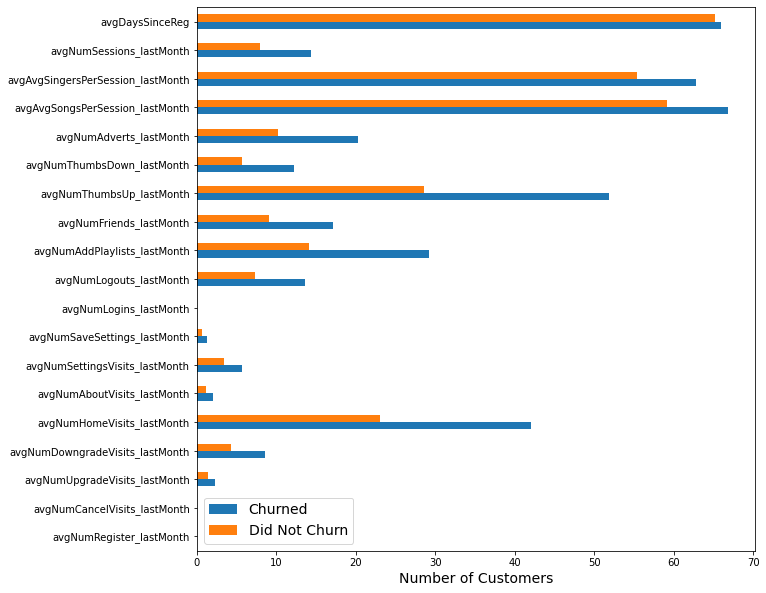

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
all_data_pd_1.drop('churn', axis=1).T.plot.barh(ax=ax);
ax.set_xlabel("Number of Customers", fontsize=14)
ax.legend(["Churned", "Did Not Churn"], fontsize=14);

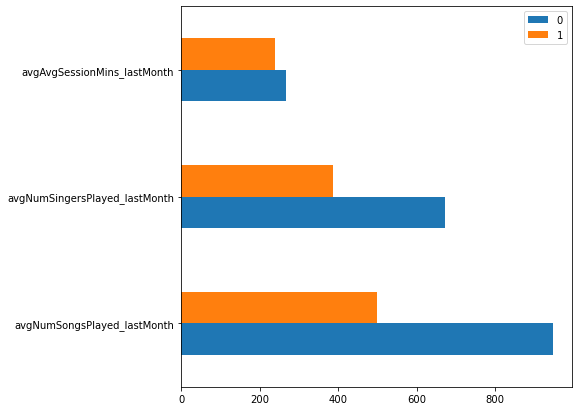

In [58]:
all_data_pd_2.drop('churn', axis=1).T.plot.barh(figsize=(7,7));

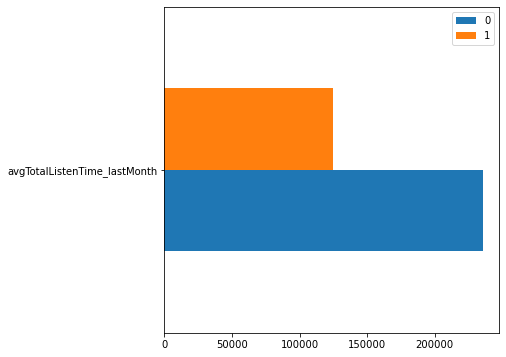

In [59]:
all_data_pd_3.drop('churn', axis=1).T.plot.barh(figsize=(6,6));

In [60]:
# 'level_lastMonth', 'gender',

all_data_pd_4 = all_data \
.filter(all_data.month_num>=1) \
.select('level_lastMonth', 'churn') \
.groupBy('churn') \
.agg(count(all_data.level_lastMonth).alias('level_lastMonth')).toPandas()

In [61]:
all_data \
.filter(all_data.month_num>=1) \
.select('level_lastMonth', 'churn') \
.groupBy('churn', 'level_lastMonth').count().show()

+-----+---------------+-----+
|churn|level_lastMonth|count|
+-----+---------------+-----+
|    1|              0|    6|
|    0|              1|   93|
|    0|              0|   53|
|    1|              1|   37|
|    0|           null|   12|
+-----+---------------+-----+



In [62]:
all_data_pd_4 = all_data \
.filter(all_data.month_num>=1) \
.select('level_lastMonth', 'churn') \
.groupBy('churn', 'level_lastMonth').count().toPandas()

In [63]:
all_data_pd_4.head()

,churn,level_lastMonth,count
0,1,0,6
1,0,1,93
2,0,0,53
3,1,1,37
4,0,None,12


In [64]:
all_data_pd_4.groupby(['churn', 'level_lastMonth']).agg({'count':'sum'})

count
churn level_lastMonth       
0     0                   53
      1                   93
1     0                    6
      1                   37

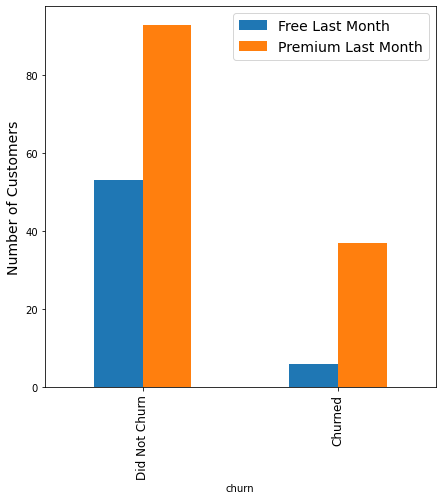

In [65]:
fig, ax = plt.subplots(figsize=(7,7));
all_data_pd_4.groupby(['churn', 'level_lastMonth']).agg({'count':'sum'}).unstack().plot.bar(ax=ax);
ax.legend(["Free Last Month", "Premium Last Month"], fontsize=14);
ax.set_xticklabels(["Did Not Churn","Churned"], fontsize=12);
ax.set_ylabel("Number of Customers", fontsize=14);

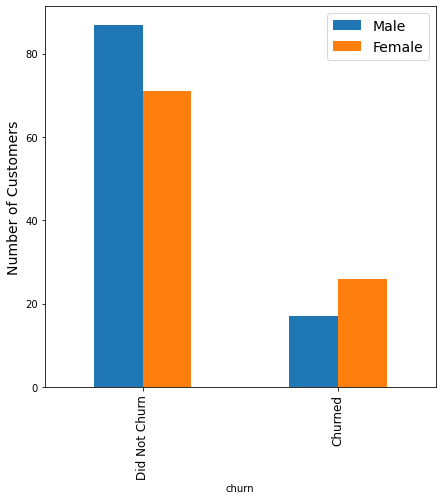

In [66]:
all_data_pd_5 = all_data \
.filter(all_data.month_num>=1) \
.select('gender', 'churn') \
.groupBy('churn', 'gender').count().toPandas()

all_data_pd_5.groupby(['churn', 'gender']).agg({'count':'sum'})

fig, ax = plt.subplots(figsize=(7,7));
all_data_pd_5.groupby(['churn', 'gender']).agg({'count':'sum'}).unstack().plot.bar(ax=ax);
ax.legend(["Male", "Female"], fontsize=14);
ax.set_xticklabels(["Did Not Churn","Churned"], fontsize=12);
ax.set_ylabel("Number of Customers", fontsize=14);

Old method of visualizing data. This involved converting the whole Spark dataframe into a pandas dataframe, which is not an efficient and parallelizable procedure.

In [67]:
# visualize 1 month lag values
all_data_pd = all_data \
.filter(all_data.month_num>=1) \
.select('numRegister_lastMonth','numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth',\
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
        'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
        'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
        'level_lastMonth', 'gender', 'daysSinceReg', 'churn'
        ).toPandas()

In [68]:
all_data_pd.head()

,numRegister_lastMonth,numCancelVisits_lastMonth,numUpgradeVisits_lastMonth,numDowngradeVisits_lastMonth,numHomeVisits_lastMonth,numAboutVisits_lastMonth,numSettingsVisits_lastMonth,numSaveSettings_lastMonth,numLogins_lastMonth,numLogouts_lastMonth,...,totalListenTime_lastMonth,avgSongsPerSession_lastMonth,numSingersPlayed_lastMonth,avgSingersPerSession_lastMonth,avgSessionMins_lastMonth,numSessions_lastMonth,level_lastMonth,gender,daysSinceReg,churn
0,0,0,0,3,21,2,5,0,0,5,...,113208.89566,153.000000,406,140.333333,625.066667,3,1,0,34,0
1,0,0,0,14,51,9,7,3,0,17,...,299251.95930,70.941176,898,66.470588,289.469608,17,1,0,36,1
2,0,0,0,0,1,0,0,0,0,0,...,695.82231,3.000000,3,3.000000,7.700000,1,1,1,129,0
3,0,0,0,2,5,0,0,0,0,1,...,48398.48971,95.500000,180,91.000000,398.516667,2,1,1,159,0
4,0,0,3,8,29,0,5,1,0,9,...,100942.41520,34.416667,369,33.333333,141.411111,12,1,1,145,0


In [69]:
all_data_pd['numCancelVisits_lastMonth'].head()

0    0
1    0
2    0
3    0
4    0
Name: numCancelVisits_lastMonth, dtype: int64

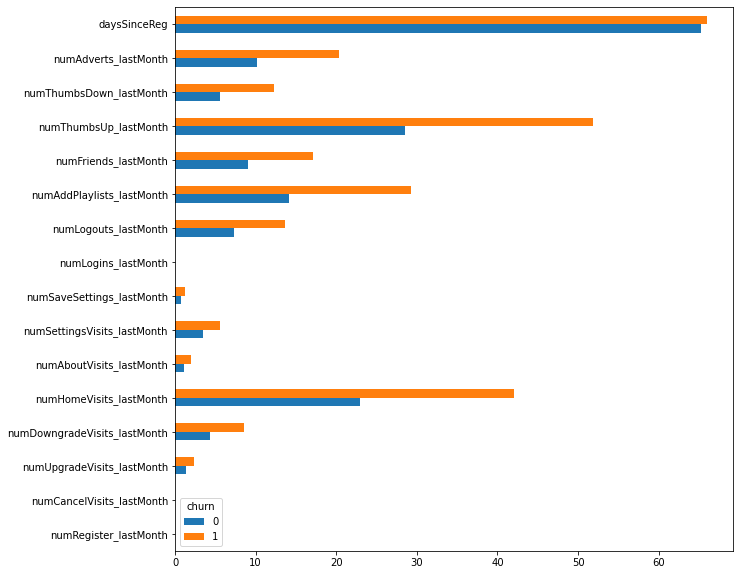

In [70]:
all_data_pd.groupby('churn').agg({'numRegister_lastMonth':'mean',\
                                  'numCancelVisits_lastMonth':'mean',\
                                  'numUpgradeVisits_lastMonth':'mean',\
                                  'numDowngradeVisits_lastMonth':'mean',\
                                  'numHomeVisits_lastMonth':'mean',\
                                  'numAboutVisits_lastMonth':'mean',\
                                  'numSettingsVisits_lastMonth':'mean',\
                                  'numSaveSettings_lastMonth':'mean',\
                                  'numLogins_lastMonth':'mean',\
                                  'numLogouts_lastMonth':'mean',\
                                  'numAddPlaylists_lastMonth':'mean',\
                                  'numFriends_lastMonth':'mean',\
                                  'numThumbsUp_lastMonth':'mean',\
                                  'numThumbsDown_lastMonth':'mean',\
                                  'numAdverts_lastMonth':'mean',\
                                  'daysSinceReg':'mean'
                                  #'numSongsPlayed_lastMonth':'mean'
                                  #'totalListenTime_lastMonth':'mean'
                                 }).T.plot.barh(figsize=(10,10));

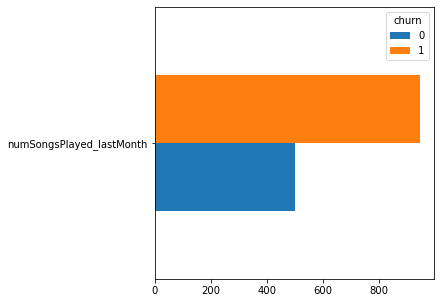

In [71]:
all_data_pd.groupby('churn').agg({'numSongsPlayed_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

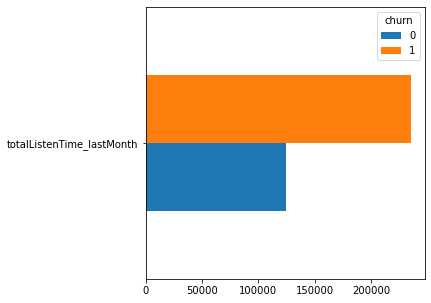

In [72]:
all_data_pd.groupby('churn').agg({'totalListenTime_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

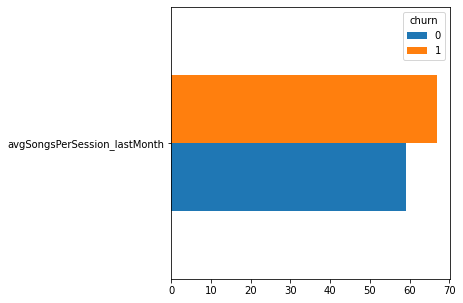

In [73]:
all_data_pd.groupby('churn').agg({'avgSongsPerSession_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

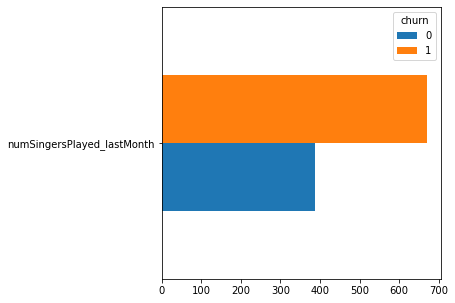

In [74]:
all_data_pd.groupby('churn').agg({'numSingersPlayed_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

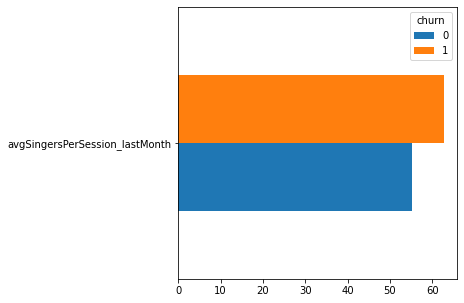

In [75]:
all_data_pd.groupby('churn').agg({'avgSingersPerSession_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

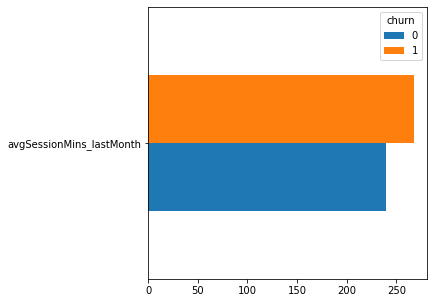

In [76]:
all_data_pd.groupby('churn').agg({'avgSessionMins_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

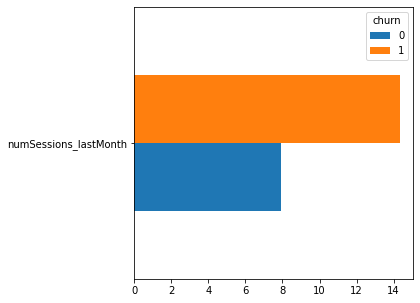

In [77]:
all_data_pd.groupby('churn').agg({'numSessions_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

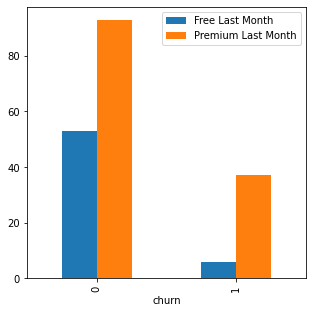

In [78]:
fig, ax = plt.subplots(figsize=(5,5))
all_data_pd.groupby(['churn', 'level_lastMonth']).agg({'level_lastMonth':'count'}).unstack().plot.bar(ax=ax);
ax.legend(["Free Last Month", "Premium Last Month"]);

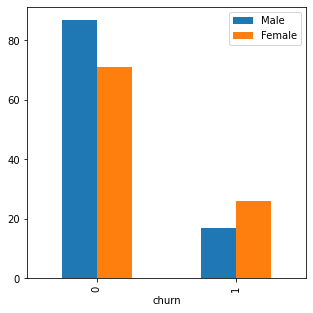

In [79]:
fig, ax = plt.subplots(figsize=(5,5))
all_data_pd.groupby(['churn', 'gender']).agg({'gender':'count'}).unstack().plot.bar(ax=ax);
ax.legend(["Male", "Female"]);

In [80]:
all_data_pd.churn.value_counts()

0    158
1     43
Name: churn, dtype: int64

# Feature Engineering


In [81]:
# Engineer diffs between last months stats and moving averages.
# for the small dataset, the differences will be 0 since there were only 2 months
all_data = all_data.withColumn('diff_numRegister', (all_data['numRegister_lastMonth'] - all_data['numRegister_movAvg']))
all_data = all_data.withColumn('diff_numCancelVisits', (all_data['numCancelVisits_lastMonth'] - all_data['numCancelVisits_movAvg']))
all_data = all_data.withColumn('diff_numUpgradeVisits', (all_data['numUpgradeVisits_lastMonth'] - all_data['numUpgradeVisits_movAvg']))
all_data = all_data.withColumn('diff_numDowngradeVisits', (all_data['numDowngradeVisits_lastMonth'] - all_data['numDowngradeVisits_movAvg']))
all_data = all_data.withColumn('diff_numHomeVisits', (all_data['numHomeVisits_lastMonth'] - all_data['numHomeVisits_movAvg']))
all_data = all_data.withColumn('diff_numAboutVisits', (all_data['numAboutVisits_lastMonth'] - all_data['numAboutVisits_movAvg']))
all_data = all_data.withColumn('diff_numSettingsVisits', (all_data['numSettingsVisits_lastMonth'] - all_data['numSettingsVisits_movAvg']))
all_data = all_data.withColumn('diff_numSaveSettings', (all_data['numSaveSettings_lastMonth'] - all_data['numSaveSettings_movAvg']))
all_data = all_data.withColumn('diff_numLogins', (all_data['numLogins_lastMonth'] - all_data['numLogins_movAvg']))
all_data = all_data.withColumn('diff_numLogouts', (all_data['numLogouts_lastMonth'] - all_data['numLogouts_movAvg']))
all_data = all_data.withColumn('diff_numAddPlaylists', (all_data['numAddPlaylists_lastMonth'] - all_data['numAddPlaylists_movAvg']))
all_data = all_data.withColumn('diff_numFriends', (all_data['numFriends_lastMonth'] - all_data['numFriends_movAvg']))
all_data = all_data.withColumn('diff_numThumbsUp', (all_data['numThumbsUp_lastMonth'] - all_data['numThumbsUp_movAvg']))
all_data = all_data.withColumn('diff_numThumbsDown', (all_data['numThumbsDown_lastMonth'] - all_data['numThumbsDown_movAvg']))
all_data = all_data.withColumn('diff_numAdverts', (all_data['numAdverts_lastMonth'] - all_data['numAdverts_movAvg']))
all_data = all_data.withColumn('diff_numSongsPlayed', (all_data['numSongsPlayed_lastMonth'] - all_data['numSongsPlayed_movAvg']))
all_data = all_data.withColumn('diff_totalListenTime', (all_data['totalListenTime_lastMonth'] - all_data['totalListenTime_movAvg']))
all_data = all_data.withColumn('diff_avgSongsPerSession', (all_data['avgSongsPerSession_lastMonth'] - all_data['avgSongsPerSession_movAvg']))
all_data = all_data.withColumn('diff_numSingersPlayed', (all_data['numSingersPlayed_lastMonth'] - all_data['numSingersPlayed_movAvg']))
all_data = all_data.withColumn('diff_avgSingersPerSession', (all_data['avgSingersPerSession_lastMonth'] - all_data['avgSingersPerSession_movAvg']))
all_data = all_data.withColumn('diff_avgSessionMins', (all_data['avgSessionMins_lastMonth'] - all_data['avgSessionMins_movAvg']))
all_data = all_data.withColumn('diff_numSessions', (all_data['numSessions_lastMonth'] - all_data['numSessions_movAvg']))

In [82]:
all_data.show(3)

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+-------------------+---------------+-----------------

In [83]:
# convert userId, gender, level, level_lastMonth to numeric
convert_numeric = ['userId', 'level', 'gender', 'level_lastMonth']
for feat in convert_numeric:
    featName = feat + "_n"
    all_data = all_data.withColumn(featName, all_data[feat].cast("float"))
    all_data = all_data.drop(feat)

In [84]:
# fill na/null values with 0
all_data = all_data.na.fill(0.0)

In [133]:
all_data1=all_data.toPandas()

In [134]:
all_data1.to_csv("all_data.csv",header=True)

In [135]:
# If needed
out_path = "all_data.csv"
all_data = spark.read.csv(out_path, header=True, inferSchema=True)

In [136]:
all_data.persist()

DataFrame[_c0: int, month_num: int, numRegister: int, numCancelVisits: int, numUpgradeVisits: int, numDowngradeVisits: int, numHomeVisits: int, numAboutVisits: int, numSettingsVisits: int, numSaveSettings: int, numLogins: int, numLogouts: int, numAddPlaylists: int, numFriends: int, numThumbsUp: int, numThumbsDown: int, numAdverts: int, numSongsPlayed: int, totalListenTime: double, avgSongsPerSession: double, numSingersPlayed: int, avgSingersPerSession: double, avgSessionMins: double, numSessions: int, daysSinceReg: int, churn: int, numRegister_lastMonth: int, numCancelVisits_lastMonth: int, numUpgradeVisits_lastMonth: int, numDowngradeVisits_lastMonth: int, numHomeVisits_lastMonth: int, numAboutVisits_lastMonth: int, numSettingsVisits_lastMonth: int, numSaveSettings_lastMonth: int, numLogins_lastMonth: int, numLogouts_lastMonth: int, numAddPlaylists_lastMonth: int, numFriends_lastMonth: int, numThumbsUp_lastMonth: int, numThumbsDown_lastMonth: int, numAdverts_lastMonth: int, numSongsPl

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [137]:
all_data.columns

['_c0',
 'month_num',
 'numRegister',
 'numCancelVisits',
 'numUpgradeVisits',
 'numDowngradeVisits',
 'numHomeVisits',
 'numAboutVisits',
 'numSettingsVisits',
 'numSaveSettings',
 'numLogins',
 'numLogouts',
 'numAddPlaylists',
 'numFriends',
 'numThumbsUp',
 'numThumbsDown',
 'numAdverts',
 'numSongsPlayed',
 'totalListenTime',
 'avgSongsPerSession',
 'numSingersPlayed',
 'avgSingersPerSession',
 'avgSessionMins',
 'numSessions',
 'daysSinceReg',
 'churn',
 'numRegister_lastMonth',
 'numCancelVisits_lastMonth',
 'numUpgradeVisits_lastMonth',
 'numDowngradeVisits_lastMonth',
 'numHomeVisits_lastMonth',
 'numAboutVisits_lastMonth',
 'numSettingsVisits_lastMonth',
 'numSaveSettings_lastMonth',
 'numLogins_lastMonth',
 'numLogouts_lastMonth',
 'numAddPlaylists_lastMonth',
 'numFriends_lastMonth',
 'numThumbsUp_lastMonth',
 'numThumbsDown_lastMonth',
 'numAdverts_lastMonth',
 'numSongsPlayed_lastMonth',
 'totalListenTime_lastMonth',
 'avgSongsPerSession_lastMonth',
 'numSingersPlayed_las

In [138]:
# drop month 0 since we do not have old information to predict churn for this month
# keep only features to be trained and labels

model_data = all_data \
.filter(all_data.month_num>0) \
.select('userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth', \
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
        'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
        'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
        'level_lastMonth_n', 'numRegister_movAvg', 'numCancelVisits_movAvg',\
        'numUpgradeVisits_movAvg', 'numDowngradeVisits_movAvg',\
        'numHomeVisits_movAvg', 'numAboutVisits_movAvg',\
        'numSettingsVisits_movAvg', 'numSaveSettings_movAvg',\
        'numLogins_movAvg', 'numLogouts_movAvg',\
        'numAddPlaylists_movAvg', 'numFriends_movAvg',\
        'numThumbsUp_movAvg', 'numThumbsDown_movAvg',\
        'numAdverts_movAvg', 'numSongsPlayed_movAvg',\
        'totalListenTime_movAvg', 'avgSongsPerSession_movAvg',\
        'numSingersPlayed_movAvg', 'avgSingersPerSession_movAvg',\
        'avgSessionMins_movAvg', 'numSessions_movAvg',\
        'diff_numRegister', 'diff_numCancelVisits',\
        'diff_numUpgradeVisits', 'diff_numDowngradeVisits',\
        'diff_numHomeVisits', 'diff_numAboutVisits',\
        'diff_numSettingsVisits', 'diff_numSaveSettings',\
        'diff_numLogins', 'diff_numLogouts',\
        'diff_numAddPlaylists', 'diff_numFriends',\
        'diff_numThumbsUp', 'diff_numThumbsDown',\
        'diff_numAdverts', 'diff_numSongsPlayed',\
        'diff_totalListenTime', 'diff_avgSongsPerSession',\
        'diff_numSingersPlayed', 'diff_avgSingersPerSession',
        'diff_avgSessionMins', 'diff_numSessions',\
        'gender_n', 'daysSinceReg', 'churn'
        ).withColumnRenamed('churn', 'label')

model_data.show(1)

+--------+---------+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+-----------------+------------------+----------------------+-----------------------+-------------------------+--------------------+---------------------+------------------------+----------------------+----------------+-----------------+----------------------+-----------------+------------------+--------------------+-----------------+---------------------+----------------------+-------------------------+-----------------------+---

In [139]:
model_data.select([count(when(col(c).isNull(), c)).alias(c) for c in model_data.columns]).show()

+--------+---------+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+-----------------+------------------+----------------------+-----------------------+-------------------------+--------------------+---------------------+------------------------+----------------------+----------------+-----------------+----------------------+-----------------+------------------+--------------------+-----------------+---------------------+----------------------+-------------------------+-----------------------+---

In [140]:
# for small dataset with 2 months, just use randomSplit
# for bigger datasets with multiple months, can split according to months
train,test = model_data.randomSplit([0.8, 0.2], seed=50)

In [141]:
# for small dataset, just train with last month's stats since there are only 2 months
# for large dataset, can train with last month's stats, moving averages and diffs

# small dataset
inputColumns = ['userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
                'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
                'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
                'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
                'numLogins_lastMonth', 'numLogouts_lastMonth', \
                'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
                'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
                'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
                'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
                'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
                'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
                'level_lastMonth_n', 'gender_n', 'daysSinceReg']


assembler = VectorAssembler(inputCols=inputColumns, outputCol="FeaturesVec")

scaler = StandardScaler(inputCol="FeaturesVec", outputCol="features", withMean=True, withStd=True)

# Logistic Regression
lr=LogisticRegression(maxIter=30)
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

# Support Vector Machine Classifier
svc = LinearSVC(maxIter=30)
pipeline_svc = Pipeline(stages=[assembler, scaler, svc])

# Gradient Boosted Trees
gbt = GBTClassifier(maxIter=20, seed=42)
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

In [163]:
# logistic Regression

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1, 0.2, 0.5]) \
    .build()

cv_lr = CrossValidator(estimator=pipeline_lr,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=MulticlassClassificationEvaluator(),\
                       numFolds=5,\
                       seed=42
                      )
cvModel_lr = cv_lr.fit(train)

In [144]:
cvModel_lr.avgMetrics

[0.7413722350018579,
 0.7505081628406122,
 0.7466836178066806,
 0.738762684966476,
 0.7455707026004461]

In [145]:
lr_results = cvModel_lr.transform(test)

In [146]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Logistic Regression Model --- Accuracy is: ")
print(evaluator.evaluate(lr_results, {evaluator.metricName: "accuracy"}))

Logistic Regression Model --- Accuracy is: 
0.7647058823529411


In [147]:
print("Logistic Regression Model --- F1-Score is: ")
print(evaluator.evaluate(lr_results, {evaluator.metricName: "f1"}))

Logistic Regression Model --- F1-Score is: 
0.7184873949579832


In [148]:
# Linear Support Vector Machine

paramGrid = ParamGridBuilder() \
    .addGrid(svc.regParam,[0.0, 0.05, 0.1, 0.2, 0.5]) \
    .build()

cv_svc = CrossValidator(estimator=pipeline_svc,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=MulticlassClassificationEvaluator(),\
                       numFolds=5,\
                       seed=42
                      )
cvModel_svc = cv_svc.fit(train)

In [149]:
cvModel_svc.avgMetrics

[0.7359651034112633,
 0.7415853653606095,
 0.738796497668874,
 0.7018684740530533,
 0.7018684740530533]

In [150]:
svc_results = cvModel_svc.transform(test)

In [151]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Linear SVC Model --- Accuracy is: ")
print(evaluator.evaluate(svc_results, {evaluator.metricName: "accuracy"}))

Linear SVC Model --- Accuracy is: 
0.7352941176470589


In [152]:
print("Linear SVC Model --- F1-Score is: ")
print(evaluator.evaluate(svc_results, {evaluator.metricName: "f1"}))

Linear SVC Model --- F1-Score is: 
0.6231306081754736


In [153]:
# Gradient Boosted Trees
paramGrid = ParamGridBuilder() \
            .addGrid(gbt.minInstancesPerNode,[1, 5, 10, 20, 50]) \
            .addGrid(gbt.maxDepth,[5, 7, 9])\
            .addGrid(gbt.subsamplingRate,[0.5,0.75,1.0])\
            .build()

cv_gbt = CrossValidator(estimator=pipeline_gbt,\
                        estimatorParamMaps=paramGrid,\
                        evaluator=MulticlassClassificationEvaluator(),\
                        numFolds=5,\
                        seed=42
                       )
cvModel_gbt = cv_gbt.fit(train)

In [154]:
cvModel_gbt.avgMetrics

[0.7384131013255836,
 0.71347056361284,
 0.7476830207173599,
 0.7279451822421693,
 0.7066396096613266,
 0.7860966032239717,
 0.7350585891972052,
 0.7099605573201168,
 0.7817439964520101,
 0.6709793311510804,
 0.7624680853331592,
 0.7695498637898213,
 0.7105564881424801,
 0.7680765600571396,
 0.7546432061648662,
 0.6948927674543429,
 0.7663704921425428,
 0.760919720348357,
 0.7449859841781394,
 0.7833765100719113,
 0.7266470637806353,
 0.7449859841781394,
 0.795007027128785,
 0.7279799894165031,
 0.7449859841781394,
 0.795007027128785,
 0.7421169966878387,
 0.7109135684871405,
 0.7272235607167563,
 0.7299008387122655,
 0.7109135684871405,
 0.7272235607167563,
 0.7299008387122655,
 0.7109135684871405,
 0.7272235607167563,
 0.7299008387122655,
 0.7018684740530533,
 0.7018684740530533,
 0.7018684740530533,
 0.7018684740530533,
 0.7018684740530533,
 0.7018684740530533,
 0.7018684740530533,
 0.7018684740530533,
 0.7018684740530533]

In [155]:
gbt_results = cvModel_gbt.transform(test)

In [156]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("GBT Model --- Accuracy is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "accuracy"}))

GBT Model --- Accuracy is: 
0.7352941176470589


In [157]:
print("GBT Model --- F1-Score is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"}))

GBT Model --- F1-Score is: 
0.6964212258329905
